# Data Augmentation

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive # 此时colab中出现drive的文件夹，里面就是你的google drive的根目录文件

In [0]:
import os
os.chdir("drive/Colab/") 

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
import time
import math
import shutil
import os
import os.path
import pandas as pd
!pwd
#os.chdir('drive/Colab')

/content/drive/Colab


In [0]:
original_dir = r'BONC'

### I. Show a example figure

(1088, 1920, 3)

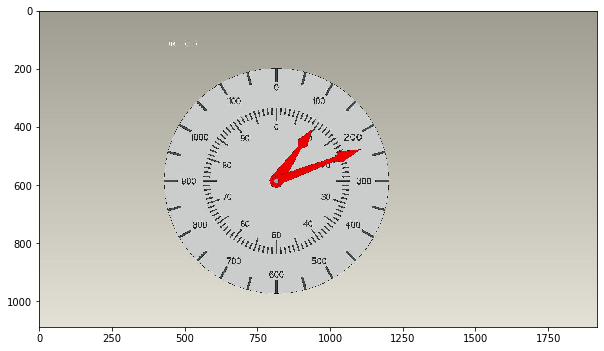

In [0]:
pic = os.path.join(original_dir,'1_1000.jpg')
im = imgplt.imread(pic)
plt.figure(figsize=(10,10))
plt.imshow(im)
im.shape

In [0]:
# 设定数据集基本参数
big_arrow_angular_speed =  180/227 #单位：度每张图片  -> degrees per image
small_arrow_angular_speed = 180/454

big_arrow_indicator = 300/90 # 一度代表的数值数 -> number per degree
small_arrow_indicator = 25/90
unit_span = 50  #罗盘单位间隔为50

- 圆心位置： b=587（纵坐标）   a=819（横坐标）   ->绝对坐标

- 指针长度：L=312(像素)  ->绝对坐标

- 横纵比： y=0.567x  ->绝对坐标

- 指针转动角速度：
    - big_arrow_angular_speed =  180/227 = 0.01384 rad/image    #单位：rad每图
    - small_arrow_angular_speed = 180/454 = 0.00692 rad/image 
- 圆方程：$(x-819)^2+(y-587)^2 = (312)^2$

- 指针终端轨迹：[(b-cos($\omega$*n))，(a+sin($\omega$*n))]  其中n为图片序号  
即指针终端轨迹像素值变化为： $$587-312*cos(0.01384*n),819+312*sin(0.01384*n)$$

#### 下面是一个剪切后图片的样本

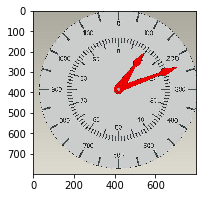

In [0]:
height_span = 800
height_start = 200
height_end = height_start+height_span
width_span = 800
width_start = 400
width_end = width_start + width_span

plt.figure(figsize=(3,3))
pic_tmp = im[height_start:height_end,width_start:width_end,:]
plt.imshow(pic_tmp)

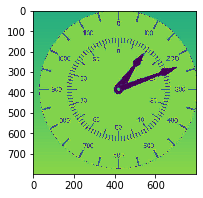

In [0]:
# Data Augmentation 也可以通过改变图片的颜色来扩充。这里由于算力不足，省略。
plt.figure(figsize=(3,3))
pic_tmp = im[height_start:height_end,width_start:width_end,2]
plt.imshow(pic_tmp)

In [0]:
!ls pic

labeled_data


## 重命名图片：将label直接记录在文件名上。
- 格式：{L- 大指针读数}{ _ }{s-小指针读数}
- 读数规则：(大指针读数//50)*50
- 注：这里根据训练集中指针运动的角速度进行标注。

In [0]:
label_dir = r'pic/labeled_data/'
if(not os.path.exists(label_dir)):
    os.mkdir(label_dir)
    print('路径不存在，已自动创建。')
    


for parent, dirnames, filenames in os.walk(original_dir):
    cnt = 1
    for file in filenames:
        big_number = int((cnt*big_arrow_angular_speed*big_arrow_indicator//unit_span)*unit_span)
        big_number %= 1200
        small_number = int(cnt*small_arrow_angular_speed*small_arrow_indicator)
        small_number %= 100
        label_filename = '{}'.format(cnt)+'L-{}'.format(big_number)+'_'+'s-{}'.format(small_number)+'.jpg'
        cnt += 1
        shutil.copyfile(os.path.join(parent,file),os.path.join(label_dir,label_filename))
print('文件标记完成。')

KeyboardInterrupt: ignored

### 生成原始图片对应的圆心、大小指针终端位置
- 大指针终端：
$$587-312cos(0.01384*n),819+312*sin(0.01384*n)$$
- 小指针终端：
$$587-218.4cos(0.00692*n),819+218.4*sin(0.00692*n)$$
- 格式：（纵坐标，横坐标）

In [0]:
circle_origin = []
big_arrow_pos = []
small_arrow_pos = []
image_name_list = []
synthesis_label = []
# 为了加速硬件运算，这里将运算结果四舍五入为整数
for parent, dirnames, filenames in os.walk(label_dir):
    cnt = 0
    image_name_list = filenames
    for file in filenames:
        circle_origin.append((587,819))
        big_arrow_pos.append((round(587-312*math.cos(0.01384*cnt)),round(819+312*math.sin(0.01384*cnt))))
        small_arrow_pos.append((round(587-218.4*math.cos(0.00692*cnt)),round(819+218.4*math.sin(0.00692*cnt))))
        synthesis_label.append((587,819)+(round(587-312*math.cos(0.01384*cnt)),round(819+312*math.sin(0.01384*cnt)))\
                              +(round(587-218.4*math.cos(0.00692*cnt)),round(819+218.4*math.sin(0.00692*cnt))))
        cnt += 1
original_annotate = pd.DataFrame({
    'circle_origin':circle_origin,
    'big_arrow_end':big_arrow_pos,
    'small_arrow_end':small_arrow_pos,
    'synthesis_label':synthesis_label},index=image_name_list)
original_annotate.sort_index(inplace=True)
original_annotate.head()


,circle_origin,big_arrow_end,small_arrow_end,synthesis_label
1000L-200_s-10.jpg,"(587, 819)","(275, 819)","(369, 819)","(587, 819, 275, 819, 369, 819)"
1001L-200_s-10.jpg,"(587, 819)","(275, 823)","(369, 821)","(587, 819, 275, 823, 369, 821)"
100L-250_s-11.jpg,"(587, 819)","(275, 828)","(369, 822)","(587, 819, 275, 828, 369, 822)"
101L-250_s-11.jpg,"(587, 819)","(275, 832)","(369, 824)","(587, 819, 275, 832, 369, 824)"
102L-250_s-11.jpg,"(587, 819)","(275, 836)","(369, 825)","(587, 819, 275, 836, 369, 825)"


#### 将方程与下图训练数据结果对比，符合，则存储DataFrame标签为csv文件。

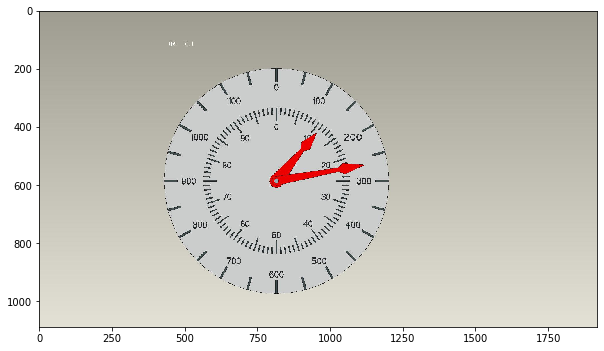

In [0]:
pic = os.path.join(label_dir,'102L-250_s-11.jpg')
im = imgplt.imread(pic)
plt.figure(figsize=(10,10))
plt.imshow(im)

In [0]:
#===================保存文件=========================
annotate_save_path = '' #直接存储

original_annotate.to_csv(os.path.join(annotate_save_path,'origin_annotate.csv'))

In [0]:
original_annotate['big_arrow_end'].to_dict()['100L-250_s-11.jpg']

(275, 828)

## Clip pictures

2 rows  9 columns
Workflow Done!


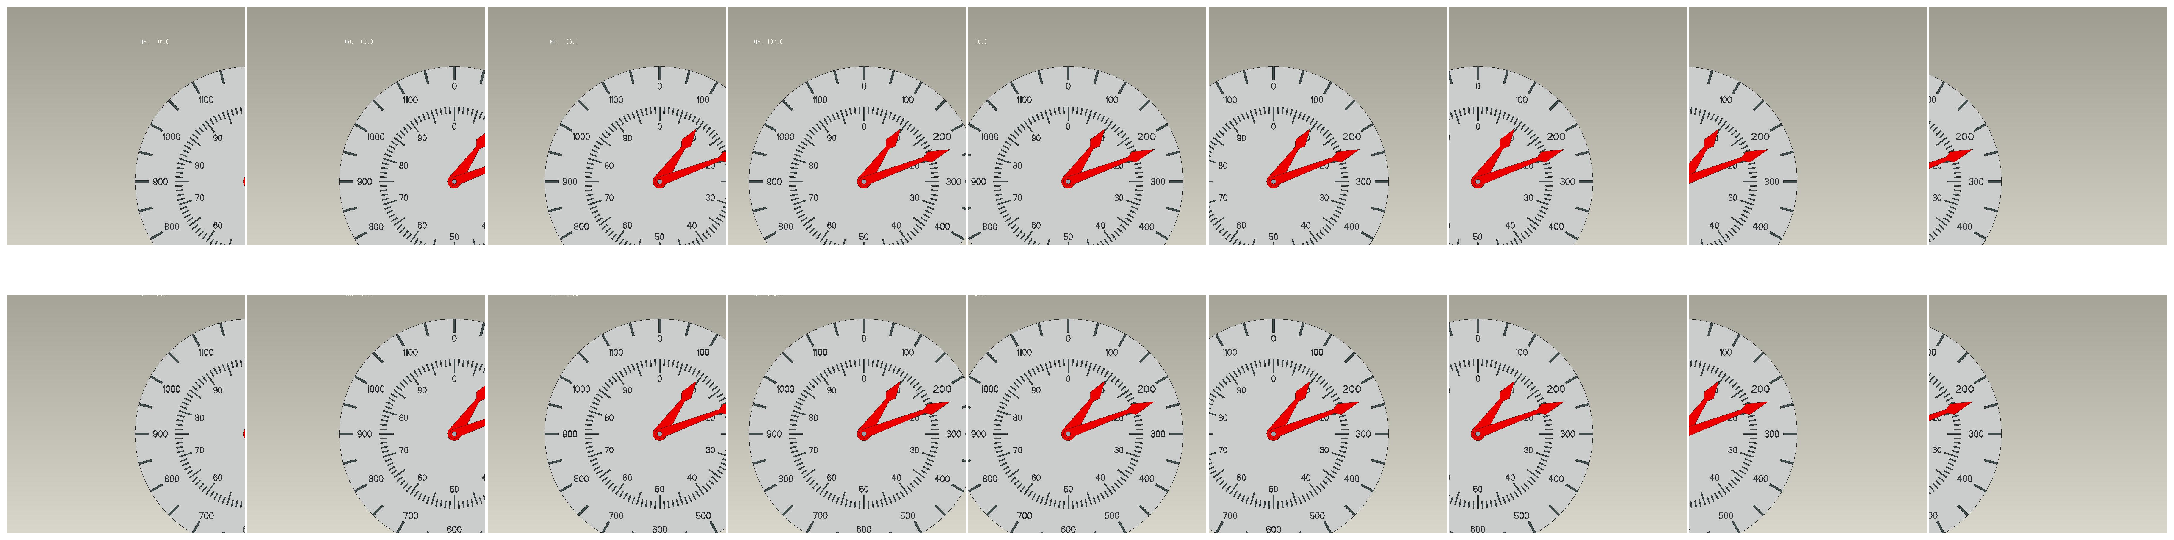

In [0]:
window = (800,800) #窗口大小   (列、行)
span = 120 # sliding window ( by pixels

plt.figure(figsize=(30,8))

horizontal_clips = (im.shape[1]-window[1])//span
vertical_clips = (im.shape[0]-window[0])//span
print(vertical_clips,'rows ',horizontal_clips,'columns')
for i in range(horizontal_clips):
    for g in range(vertical_clips):
        clipped_pic = im[g*span:g*span+window[0],i*span:i*span+window[1]]
        #print('current pixel value:',(g*span,g*span+window[1]),(g*span,g*span+window[0]))
        plt.subplot(vertical_clips,horizontal_clips,(i+1)+(g)*horizontal_clips)
        plt.axis('off')
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1,hspace=0,wspace=0.01)
        plt.imshow(clipped_pic)
print('Workflow Done!')

### Save the clipped version to disk

- 保存文件命名规则：{父文件名}_ {_ co_} {左上角像素坐标，右下角像素坐标} 

待剪切文件数： 1001
正在剪切 1_0000.jpg
                   circle_origin big_arrow_end small_arrow_end
1_0000_120_800.png    (587, 699)    (275, 699)      (369, 699)
1_0000_120_920.png    (467, 699)    (155, 699)      (249, 699)
1_0000_240_800.png    (587, 579)    (275, 579)      (369, 579)
1_0000_240_920.png    (467, 579)    (155, 579)      (249, 579)
1_0000_360_800.png    (587, 459)    (275, 459)      (369, 459)
1_0000_360_920.png    (467, 459)    (155, 459)      (249, 459)
1_0000_480_800.png    (587, 339)    (275, 339)      (369, 339)
1_0000_480_920.png    (467, 339)    (155, 339)      (249, 339)
1_0000_600_800.png    (587, 219)    (275, 219)      (369, 219)
1_0000_600_920.png    (467, 219)    (155, 219)      (249, 219)
1_0000_720_800.png     (587, 99)     (275, 99)       (369, 99)
1_0000_720_920.png     (467, 99)     (155, 99)       (249, 99)
剩余文件个数： 1000 
ETA:276.14min
正在剪切 1_0001.jpg
                   circle_origin big_arrow_end small_arrow_end
1_0000_120_800.png    (587, 699)    (275, 699

                   circle_origin big_arrow_end small_arrow_end
1_0000_120_800.png    (587, 699)    (275, 699)      (369, 699)
1_0000_120_920.png    (467, 699)    (155, 699)      (249, 699)
1_0000_240_800.png    (587, 579)    (275, 579)      (369, 579)
1_0000_240_920.png    (467, 579)    (155, 579)      (249, 579)
1_0000_360_800.png    (587, 459)    (275, 459)      (369, 459)
...                          ...           ...             ...
1_0005_480_920.png    (467, 339)    (156, 361)      (249, 347)
1_0005_600_800.png    (587, 219)    (276, 241)      (369, 227)
1_0005_600_920.png    (467, 219)    (156, 241)      (249, 227)
1_0005_720_800.png     (587, 99)    (276, 121)      (369, 107)
1_0005_720_920.png     (467, 99)    (156, 121)      (249, 107)

[72 rows x 3 columns]
剩余文件个数： 995 
ETA:2415.75min
正在剪切 1_0006.jpg
                   circle_origin big_arrow_end small_arrow_end
1_0000_120_800.png    (587, 699)    (275, 699)      (369, 699)
1_0000_120_920.png    (467, 699)    (155, 699)     

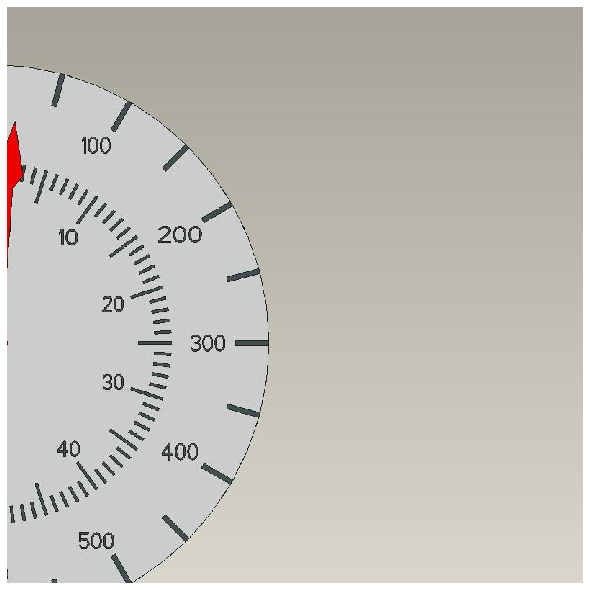

In [0]:
save_path = r'data_augmentation\clipped_picture'

if(not os.path.exists(save_path)):
    os.mkdir(save_path)
    print('路径不存在，已自动创建。')
    
plt.figure(figsize=(window[1]//100,window[0]//100))

qualified_file_names = []
clipped_circle_origin = []
clipped_big_arrow_end = []
clipped_small_arrow_end = []
clipped_annotation = pd.DataFrame()
try:
    for parent, dirnames, filenames in os.walk(label_dir):
        print('待剪切文件数：',len(filenames))
        cnt = 0
        for file in filenames:
            original_annotation = original_annotate.loc[file] #读取裁剪前文件标记
            # 裁剪文件
            start_time = time.time()
            print('正在剪切',file)
            image_to_clip = imgplt.imread(os.path.join(parent,file))
            for i in range(horizontal_clips):
                for g in range(vertical_clips):
                    clipped_pic = image_to_clip[g*span:g*span+window[0],i*span:i*span+window[1]]
                    name_of_file = os.path.splitext(file)[0]+'_{}_{}'.format(i*span,g*span+window[0])+'.png'
                    plt.axis('off')
                    plt.imshow(clipped_pic)
                    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
                    plt.margins(0,0)
                    plt.savefig(os.path.join(save_path,name_of_file), format='png', transparent=True, dpi=100, pad_inches = 0)
                                      
                    # 保存annotation
                    tmp_big_arrow_end = original_annotate['big_arrow_end'].to_dict()[file]
                    tmp_small_arrow_end = original_annotate['small_arrow_end'].to_dict()[file]
                    tmp_circle_origin = original_annotate['circle_origin'].to_dict()[file]
                    #判断大小箭头是否都在window内
                    turbulance = 5 # 扰动像素值，防止箭头在边界看不清楚
                    g_upper_bound = g*span+turbulance
                    g_lower_bound = g*span+window[0]-turbulance
                    i_upper_bound = i*span+turbulance
                    i_lower_bound = i*span+window[1]-turbulance
                    if(tmp_big_arrow_end[0]>g_upper_bound and tmp_big_arrow_end[0]<g_lower_bound \
                      and tmp_small_arrow_end[0]>g_upper_bound and tmp_small_arrow_end[0]<g_lower_bound):
                        if(tmp_big_arrow_end[1]> i_upper_bound and tmp_big_arrow_end[1]< i_lower_bound \
                          and tmp_small_arrow_end[1]>i_upper_bound and tmp_small_arrow_end[1]<i_lower_bound ):
                            qualified_file_names.append(name_of_file)
                            # 将裁剪前大小箭头的绝对坐标转换至裁剪后大小箭头的绝对坐标
                            clipped_circle_origin.append((tmp_circle_origin[0]-g*span,tmp_circle_origin[1]-i*span))
                            clipped_big_arrow_end.append((tmp_big_arrow_end[0]-g*span,tmp_big_arrow_end[1]-i*span))
                            clipped_small_arrow_end.append((tmp_small_arrow_end[0]-g*span,tmp_small_arrow_end[1]-i*span))
            clipped_annotation= [clipped_annotation,pd.DataFrame({
                                'circle_origin':clipped_circle_origin,
                                'big_arrow_end':clipped_big_arrow_end,
                                'small_arrow_end':clipped_small_arrow_end},index=qualified_file_names)]
            clipped_annotation = pd.concat(clipped_annotation)
            #clipped_annotation.to_csv(os.path.join(save_path,'clipped_valid_samples.csv'))
            qualified_file_names = []
            clipped_circle_origin = []
            clipped_big_arrow_end = []
            clipped_small_arrow_end = []
            print(clipped_annotation)

            cnt += 1
            end_time = time.time()
            #预估剩余时间
            print('剩余文件个数：',len(filenames)-cnt,'\nETA:{:.2f}hrs'.format((end_time-start_time)*(len(filenames)-cnt)/3600))
    print('裁剪完成。')
    clipped_annotation.to_csv(os.path.join(save_path,'clipped_valid_samples.csv'))
    #clipped_annotation.to_csv(os.path.join(save_path,'clipped_valid_samples.csv'))
except KeyboardInterrupt:
    print('='*5,'剪裁终止。','='*5)
    print(clipped_annotation)
    clipped_annotation.to_csv(os.path.join(save_path,'clipped_valid_samples.csv'))

circle_origin      (467, 819)
big_arrow_end      (155, 819)
small_arrow_end    (249, 819)
Name: 1_0000_0_920.png, dtype: object


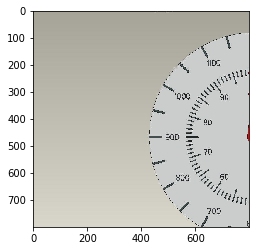

In [0]:
pic = os.path.join(save_path,'1_0000_0_920.png')
im = imgplt.imread(pic)
plt.figure(figsize=(3,3))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1,hspace=0,wspace=0.01)
plt.imshow(im)
print(clipped_annotation.loc['1_0000_0_920.png'])